## in this notebook we'll create a dataset and dataloader that returns a random sample of images from a folder

### Note: At this point I havent really worked with ImageFolder

**note!!** the following method is probably used in cases where we have a bunch of images in one folder, and a csv with 2 columns - one with the image name, and the other with the label. For cases where we do not have a csv, but have a train and test folder with subfolders that have their name as the label, we'd most likely use ImageFolder 

### let's load a test image

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.image as mpimg

In [16]:
root_dir = 'cats_dogs/images/'
csv_file = pd.read_csv('cats_dogs/cat_dog_metadata.csv')

In [43]:
image_path = os.path.join(root_dir, csv_file.iloc[0][0])
image = mpimg.imread(image_path)

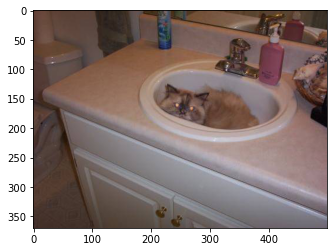

In [44]:
plt.imshow(image)

In [45]:
type(image)

numpy.ndarray

In [46]:
image.shape

(370, 500, 3)

note that the shape is of the form H x W x C. 

now let's create the custom dataset

In [20]:
class ImgDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.df.iloc[index][0])
        image = mpimg.imread(image_path)
        label = self.df.iloc[index][1]
        return image, label
    
    def __len__(self):
        return self.df.shape[0]

In [24]:
imgdataset = ImgDataset(csv_file='cats_dogs/cat_dog_metadata.csv', root_dir='cats_dogs/images/')

In [25]:
dataloader = DataLoader(imgdataset, 5)

In [28]:
next(iter(dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [370, 500, 3] at entry 0 and [168, 200, 3] at entry 1

huh. looks like we have to transform the data. let's do that

In [29]:
from torchvision import transforms

In [234]:
class ImgDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.df.iloc[index][0])
        image = mpimg.imread(image_path)
        label = self.df.iloc[index][1]
        label = torch.tensor(label, dtype=torch.float32)
        image = self.transform(image)
        return image, label
    
    def __len__(self):
        return self.df.shape[0]

In [235]:
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((150,150)),
                transforms.ToTensor(),
                transforms.Grayscale(), 
            ])

In [236]:
imgdataset = ImgDataset(csv_file='cats_dogs/cat_dog_metadata.csv', root_dir='cats_dogs/images/', transform=transform)

In [237]:
dataloader = DataLoader(imgdataset, 1)

In [238]:
sampleimage = next(iter(dataloader))
sampleimage

[tensor([[[[0.2667, 0.2785, 0.2981,  ..., 0.1955, 0.1876, 0.1719],
           [0.2707, 0.2863, 0.2981,  ..., 0.1994, 0.1915, 0.1719],
           [0.2746, 0.2903, 0.2981,  ..., 0.2033, 0.1994, 0.1837],
           ...,
           [0.1872, 0.2083, 0.2039,  ..., 0.4371, 0.4375, 0.4345],
           [0.1990, 0.2048, 0.1995,  ..., 0.4304, 0.4285, 0.4228],
           [0.1938, 0.1973, 0.1929,  ..., 0.4225, 0.4198, 0.4133]]]]),
 tensor([0.])]

In [239]:
sampleimage[0].shape

torch.Size([1, 1, 150, 150])

In [240]:
print(sampleimage[0].dtype)

torch.float32


In [241]:
print(sampleimage[1].dtype)

torch.float32


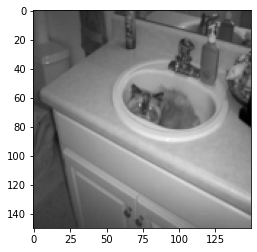

In [82]:
plt.imshow(sampleimage[0][0][0], cmap='gray')

Nice! it seems to be working. Now let's create a function to display the images created by the dataloader 

every time the function is run, a different sample will be plotted

In [127]:
def disp_dataloder_img(n=5):
    dataloader = DataLoader(imgdataset, n, shuffle=True)
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,7))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'{"cat" if labels[i].item()==0 else "dog"}')


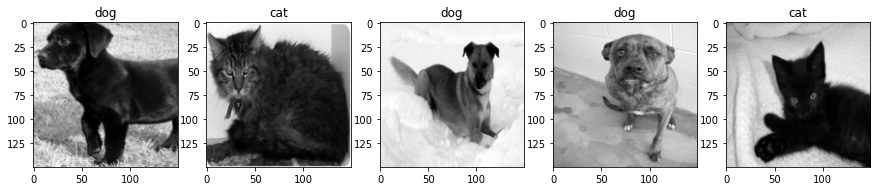

In [126]:
disp_dataloder_img()

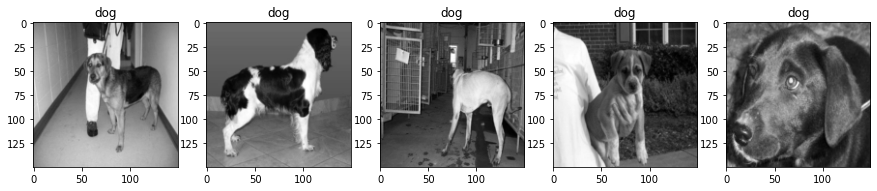

In [128]:
disp_dataloder_img()

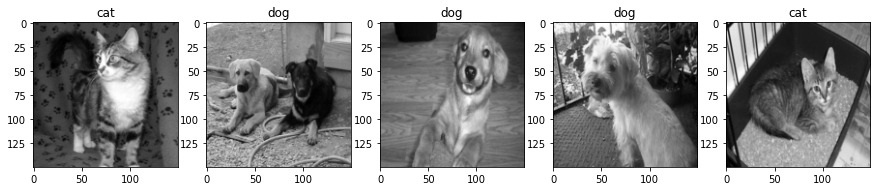

In [130]:
disp_dataloder_img()

Now if you want, you can include more transforms like horizontal flip, random rotation, random crop, etc

### Let's create a small convnet to see that everything is working as expected

In [242]:
from torch import nn
import torch.nn.functional as F

In [269]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,10,3)
        self.fc1 = nn.Linear(10*36*36, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        
        return x

#### test

In [270]:
model1 = Model1()

In [271]:
model1

Model1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12960, out_features=1, bias=True)
)

In [272]:
dataloader = DataLoader(imgdataset, 5, shuffle=True)

In [273]:
image, label = next(iter(dataloader))

In [274]:
model1(image).squeeze(1)

tensor([0.4479, 0.4240, 0.4209, 0.4381, 0.4450], grad_fn=<SqueezeBackward1>)

In [275]:
label

tensor([1., 0., 0., 0., 1.])

### train the model

In [279]:
# hyperparameters
epochs = 1
batch_size = 50

In [280]:
dataloader = DataLoader(imgdataset, batch_size, shuffle=True)

In [281]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters())

In [283]:
print_every = 5
running_loss = []
for i in range(epochs):
    for i,(image, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model1(image)
        loss = criterion(output.squeeze(1), label)
        
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        
        if i%print_every == 0:
            print(f'batch: {i}, loss: {loss.item()}')

batch: 0, loss: 0.6807689666748047
batch: 5, loss: 0.6970884799957275
batch: 10, loss: 0.6860054135322571
batch: 15, loss: 0.6758033633232117
batch: 20, loss: 0.6814460158348083
batch: 25, loss: 0.686980664730072
batch: 30, loss: 0.6468612551689148
batch: 35, loss: 0.6783046722412109


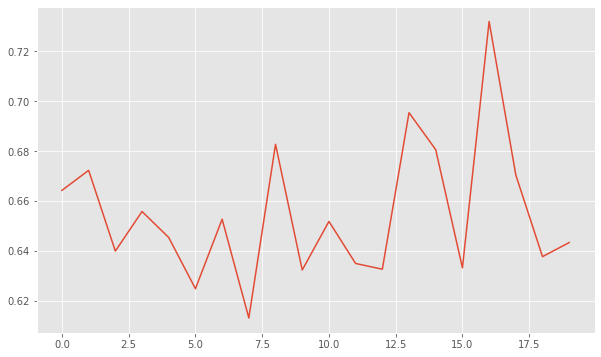

In [260]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(imgdataset)/batch_size), running_loss)

#### looks like the model is not learning anything (tried with different batch sizes). let's take a small sample of data and see if we can overfit on it 

In [285]:
samp_images, samp_labels = next(iter(dataloader))

In [286]:
samp_images.shape

torch.Size([50, 1, 150, 150])

In [287]:
samp_labels.shape

torch.Size([50])

now lets run the model on the same data for several epochs

In [288]:
print_every = 10
running_loss = []
for i in range(100):
    optimizer.zero_grad()
    output = model1(samp_images)
    loss = criterion(output.squeeze(1), samp_labels)

    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

    if i%print_every == 0:
        print(f'epoch: {i}, loss: {loss.item()}')

epoch: 0, loss: 0.6894001960754395
epoch: 10, loss: 0.6149330735206604
epoch: 20, loss: 0.4681580662727356
epoch: 30, loss: 0.3413417339324951
epoch: 40, loss: 0.2204865962266922
epoch: 50, loss: 0.11824029684066772
epoch: 60, loss: 0.057082511484622955
epoch: 70, loss: 0.027547582983970642
epoch: 80, loss: 0.015000175684690475
epoch: 90, loss: 0.009430250152945518


**inference:** okay, so our model _can_ learn. It's probably just that it is not easy to differentiate between cats and dogs, and we may need a more complex model, better image transformations, and more epochs of training 

#### let's train the same model again using more epochs

In [289]:
# hyperparameters
epochs = 10
batch_size = 50

In [290]:
print_every = 5 # print every x batches
running_loss = []
for e in range(epochs):
    for i,(image, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model1(image)
        loss = criterion(output.squeeze(1), label)
        
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        
        if i%print_every == 0:
            print(f'epoch: {e}, batch: {i}, loss: {loss.item()}')

epoch: 0, batch: 0, loss: 2.3669381141662598
epoch: 0, batch: 5, loss: 0.9111987352371216
epoch: 0, batch: 10, loss: 0.9227540493011475
epoch: 0, batch: 15, loss: 0.8060934543609619
epoch: 0, batch: 20, loss: 0.6897993683815002
epoch: 0, batch: 25, loss: 0.6624581813812256
epoch: 0, batch: 30, loss: 0.8102642297744751
epoch: 0, batch: 35, loss: 0.9089398384094238
epoch: 1, batch: 0, loss: 0.7653239369392395
epoch: 1, batch: 5, loss: 0.656903088092804
epoch: 1, batch: 10, loss: 0.7454895973205566
epoch: 1, batch: 15, loss: 0.6353802680969238
epoch: 1, batch: 20, loss: 0.6153275966644287
epoch: 1, batch: 25, loss: 0.7857708930969238
epoch: 1, batch: 30, loss: 0.8267223834991455
epoch: 1, batch: 35, loss: 0.6936385631561279
epoch: 2, batch: 0, loss: 0.669238805770874
epoch: 2, batch: 5, loss: 0.7943584322929382
epoch: 2, batch: 10, loss: 0.6709005236625671
epoch: 2, batch: 15, loss: 0.7122215032577515
epoch: 2, batch: 20, loss: 0.669517993927002
epoch: 2, batch: 25, loss: 0.62164819240570

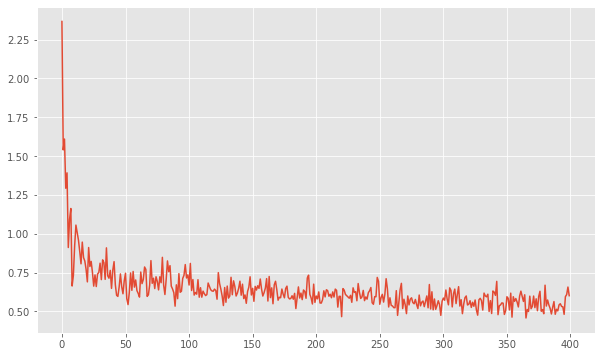

In [291]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,(len(imgdataset)/batch_size)*epochs), running_loss)

### Conclusion

As suspected, the model _was_ learning, albeit very slowly